In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [21]:
from utils import read_dataset, plot_confusion_matrix
from models import RNNModel, ComplexRNNModel
from constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS

## Reading the dataset 

In [3]:
all_trials = read_dataset("passive_trials.h5")

In [5]:
X = []
Y = []

for trial in all_trials:
    X.append(np.array(trial[BASIC_TRAINING_COLS]).astype(np.float32))
    Y.append(np.argmax(np.array(trial[FORCE_CLASS_COLS].iloc[0])))

X = np.array(X)
Y = np.array(Y)

In [7]:
np.unique(Y, return_counts=True)

(array([0, 1, 2]), array([250, 253, 297]))

In [8]:
X.shape, Y.shape

((800, 1801, 16), (800,))

# Splitting data and normalising

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state = 42, stratify=Y)

### Majority class has a \% of examples

In [10]:
class_counts = np.unique(Y_train, return_counts=True)
np.max(class_counts[1]) / np.sum(class_counts[1])

0.371875

### Normalising data

In [11]:
attr_means = X_train.reshape(-1, 16).mean(axis=0)
attr_std = X_train.reshape(-1, 16).std(axis=0)

In [12]:
X_train_scaled = (X_train - attr_means) / attr_std
X_val_scaled = (X_val - attr_means) / attr_std

### Creating Tensor Dataset

In [13]:
X_train = torch.from_numpy(X_train_scaled)
X_val = torch.from_numpy(X_val_scaled)

In [14]:
Y_train = torch.from_numpy(Y_train).type(torch.LongTensor) 
Y_val = torch.from_numpy(Y_val).type(torch.LongTensor)

In [15]:
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [16]:
np.random.seed(0)

hidden_dim = 8
layer_dim = 1
input_dim = 16    # input dimension
first_hidden_dim = 12  # hidden layer dimension
second_hidden_dim = 6     # number of hidden layers
output_dim = 3   # output dimension

model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epoch_losses = []
epoch_accuracies = []

In [ ]:
num_epochs = 200

for epoch in  tqdm(range(num_epochs)):
    
    epoch_loss = 0
    
    for i, (x, y) in enumerate(train_loader):
        
        x = Variable(x)
        y = Variable(y)
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        y_hat = model(x)
            
        # Calculate softmax and ross entropy loss
        loss = error(y_hat, y)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        epoch_loss += loss.item()
        
    epoch_losses.append(epoch_loss)
    
    correct = 0
    total = 0

    for x_test, y_test in test_loader:
        x_test = Variable(x_test)
        y_hat = model(x_test)

        predicted = torch.max(y_hat.data, 1)[1]
        
        total += y_test.size(0)
        correct += (predicted == y_test).sum()

    accuracy = 100 * correct / float(total)
    
    epoch_accuracies.append(accuracy)
    
    print(epoch_losses[-1], epoch_accuracies[-1])

In [ ]:
plt.plot(epoch_losses)

In [ ]:
plt.plot(epoch_accuracies)

torch.save(model.state_dict(), "force_model2.pt")

In [17]:
model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model.load_state_dict(torch.load("force_model2.pt"))
model.eval()

ComplexRNNModel(
  (lstm): LSTM(16, 12, batch_first=True)
  (lstm_2): LSTM(12, 6, batch_first=True)
  (fc): Linear(in_features=6, out_features=3, bias=True)
)

In [18]:
predicted = []
for x_val, y_val in val_loader:
    x_val = Variable(x_val)
    y_hat = model(x_val)

    predicted.extend(torch.max(y_hat.data, 1)[1])

In [19]:
len(predicted)

160

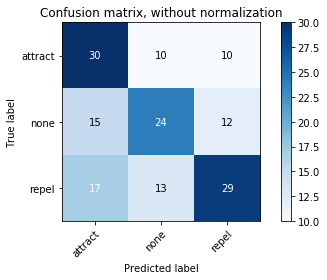

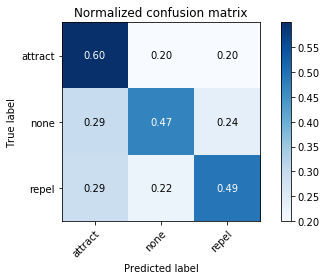

In [20]:
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=True)